# Ejercicio 3
Implementar el algoritmo de perceptrón multicapa (sin librerías)

In [1]:
import sys; sys.path.append("..")

import numpy as np
np.random.seed(2)

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

from src.perceptron_multicapa import PerceptronMulticapa, Layer
from src.optimizer import SGD, Momentum, RMSprop, AdaGrad, Adam

In [2]:
def predict(p, x, y):
    y_hat = p.predict(x)
    
    print("Entrada\t\tReal\tPred.")
    for x_true, y_true, y_pred in zip(x, y, y_hat):
        print("({:>2.0f}, {:>2.0f}):\t{:>2.0f}\t{:>2.0f}".format(*x_true, y_true, y_pred))

# Función Lógica XOR
Aprendizaje de la función presentada en el primer ejercicio, con los mismos datos y misma salida esperada. Este ejercicio es una herramienta para validar la correcta implementación de la red neuronal. 

In [3]:
x = np.array([(-1, 1), (1, -1), (-1, -1), (1, 1)])
y = np.array([1, 1, -1, -1])

In [4]:
opt = SGD()
l1 = Layer(dims_in=2, dims_out=10, activation_function="sigmoid")
l2 = Layer(dims_in=10, dims_out=2, activation_function="sigmoid")
p = PerceptronMulticapa([l1, l2], opt)

y_enc = p.one_hot_encoding(y)
history = p.train(x, y_enc)

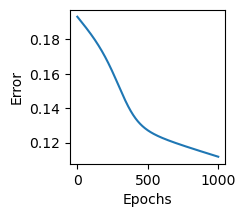

In [5]:
ax, fig = plt.subplots(figsize=(2,2))
plt.plot(
    [d["epoch"] for d in history],
    [d["train_loss"] for d in history]
)
plt.ylabel("Error")
plt.xlabel("Epochs")
plt.show()

Se observa el correcto funcionamiento del perceptrón no lineal.

In [6]:
predict(p, x, y)

Entrada		Real	Pred.
(-1,  1):	 1	 1
( 1, -1):	 1	 1
(-1, -1):	-1	-1
( 1,  1):	-1	 1


# Discriminación de paridad
determinar si un número es par/impar, utilizando el conjunto de datos presente en el archivo “TP3-ej3-digitos.txt” (dígitos de 7x5 dimensiones).

In [7]:
x = np.loadtxt("../data/digitos.txt")
y = np.loadtxt("../data/digitos_paridad.txt")
numero = np.loadtxt("../data/digitos_valor.txt")

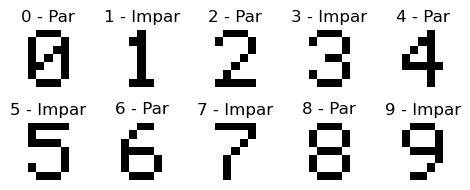

In [8]:
import itertools
n_rows = 2
n_cols = 5
fig, ax = plt.subplots(n_rows, n_cols, figsize=(5, 2))
iterable = itertools.product(range(n_rows), range(n_cols))
for n, ij in enumerate(iterable):
    ax[ij].imshow(1 - x[n].reshape(7, 5), cmap="gray")
    ax[ij].set_title("{:.0f} - {}".format(numero[n], "Par" if y[n] == 0 else "Impar"))
    ax[ij].axis("off")
plt.tight_layout()
plt.show()

### Preceptrón lineal
Como primera idea utilizaremos un perceptron simple capa lineal.

In [9]:
optimizer = Adam()
l1 = Layer(35, 2, activation_function="linear")
p = PerceptronMulticapa([l1], optimizer)

y_enc = p.one_hot_encoding(y)
history = p.train(x, y_enc, epochs=1000)

Observamos que todas las predicciones son correctas para esta estructura tan simple.

In [10]:
prediccion = p.predict(x)
(y == prediccion).all()

True

### ¿Por qué clasifica bien?
Esto se debe a que existen ciertos bits de la imagen que son exclusivos de los números pares y otros que son exclusivos de los números impares.

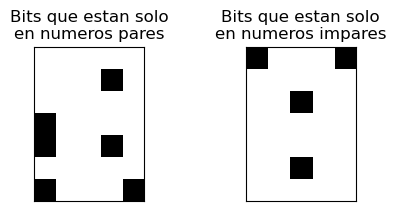

In [11]:
imagenes = x.reshape((-1, 7, 5))
pares   = sum(imagenes[::2]).astype(bool)
impares = sum(imagenes[1::2]).astype(bool)

fig, ax = plt.subplots(1, 2, figsize=(5, 2))

ax[0].imshow(~(pares & ~impares), cmap="gray")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].grid()
ax[0].set_title("Bits que estan solo\nen numeros pares")

ax[1].imshow(~(~pares & impares), cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].grid()
ax[1].set_title("Bits que estan solo\nen numeros impares")

plt.grid()
plt.show()

En rosa vemos estos bits unicos solapados sobre el conjunto de datos.
Los bits unicos impares se solapan sobre los numeros pares para mostrar que nunca se superponen.

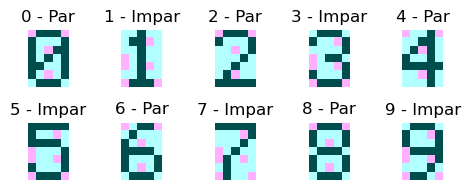

In [12]:
import itertools
n_rows = 2
n_cols = 5
fig, ax = plt.subplots(n_rows, n_cols, figsize=(5, 2))
iterable = itertools.product(range(n_rows), range(n_cols))
for n, ij in enumerate(iterable):
    if y[n] == 0:
        ax[ij].imshow((~pares & impares), cmap="cool")
        ax[ij].imshow(1 - x[n].reshape(7, 5), cmap="gray", alpha=0.7)
        ax[ij].set_title("{:.0f} - {}".format(numero[n], "Par"))
    else:
        ax[ij].imshow((pares & ~impares), cmap="cool")
        ax[ij].imshow(1 - x[n].reshape(7, 5), cmap="gray", alpha=0.7)
        ax[ij].set_title("{:.0f} - {}".format(numero[n], "Impar"))
    ax[ij].axis("off")
plt.tight_layout()
plt.show()

In [13]:
p.predict(x)

[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]

In [14]:
y

array([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])

## ¿Y si tubieramos numeros y no imagenes?
En este caso el conjunto de datos no es linealmente separable.

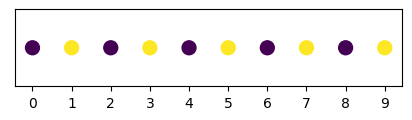

In [15]:
x = np.arange(10)
y = (x % 2)

ax, fig = plt.subplots(figsize=(5,1))
plt.scatter(x, np.zeros_like(x), c=y, s=100)
plt.yticks([])
plt.xticks(x)
plt.show()

### Arquitectura planteada

Sin embargo podriamos aproximarlo con un perceptrón multicapa. Para un perceptrón multicapa tenemos que la dimensión $VC$ es de :

* Al menos $E$,
* A lo sumo $E^2 + V^2$,

donde $E$ es la cantidad de conexiones y $V$ la cantidad de neuronas. [(Wikipedia)](https://en.wikipedia.org/wiki/Vapnik%E2%80%93Chervonenkis_dimension#VC_dimension_of_a_neural_network)

Es decir que una red con 10 capas ocultas podría clasificar correctamente el conjunto. Pero usaremos una arquitectura un poco más grande para asegurar que clasifique correctamente.



In [16]:
l1 = Layer(dims_in=1,  dims_out=20,  activation_function="sigmoid")
l2 = Layer(dims_in=20, dims_out=10 , activation_function="sigmoid")
l3 = Layer(dims_in=10, dims_out=2 ,  activation_function="sigmoid")

opt = Adam()
opt.learning_rate = 0.01
p = PerceptronMulticapa([l1, l2, l3], opt)

x = np.arange(10).reshape((-1, 1))
y = (x % 2).reshape(-1)
y_enc = p.one_hot_encoding(y)

Vamos a entrenar la red hasta que pueda catalogar correctamente el conjunto de datos.

In [17]:
prediccion = p.predict(x)
n = 0
while (prediccion != y).any() and n < 10:
    history = p.train(x, y_enc, epochs=1_000)
    prediccion = p.predict(x)
    n += 1
prediccion

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

### Numeros nunca vistos
Veremos como generaliza para números nunca antes vistos.

In [18]:
x = (10 + np.arange(10)).reshape((-1, 1))
y = (x % 2).reshape(-1)

p.predict(x)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Claramente, no se puede generalizar correctamente este problema.

## Clasificar números primos
Quizás es más interesante evaluar más rapidamente si un número es primo o no, para eso podemos construir el dataset y poner a entrenar un perceptrón no lineal.

In [19]:
def es_primo(x):
    for n in range(2, x):
        if x % n == 0:
            return 0
    return 1

In [20]:
x = np.arange(100)
y = np.vectorize(es_primo)(x)
x[y == 1]

array([ 0,  1,  2,  3,  5,  7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47,
       53, 59, 61, 67, 71, 73, 79, 83, 89, 97])

### Arquitectura del perceptrón
Para este caso vamos a tomar una arquitectura similar a la usada para los números pares/impares. Un Perceptrón multicapa con una capa oculta.

In [21]:
l1 = Layer(dims_in=1,  dims_out=20,  activation_function="sigmoid")
l2 = Layer(dims_in=20, dims_out=20 , activation_function="sigmoid")
l3 = Layer(dims_in=20, dims_out=2 ,  activation_function="sigmoid")

opt = Momentum()
opt.learning_rate = 0.001
p = PerceptronMulticapa([l1, l2, l3], opt)

x = x.reshape((-1, 1))
y_enc = p.one_hot_encoding(y)

In [22]:
history = p.train(x, y_enc, epochs=500, batch_size=1)

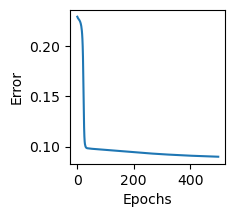

In [23]:
ax, fig = plt.subplots(figsize=(2,2))
plt.plot(
    [d["epoch"] for d in history],
    [d["train_loss"] for d in history]
)
plt.ylabel("Error")
plt.xlabel("Epochs")
plt.show()

### Accuracy
Parece que hay una rápida minimización del error.
Probemos un par de métricas con el conjunto de entrenamiento.

In [24]:
accuracy = np.mean(p.predict(x) == y)
accuracy

0.76

Un $77\%$ parece un número aceptable, pero recordemos que el accuracy se define como:

$
accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$

Lo cual deberiamos chequear, al menos, que un clasificador ingenuo (que siempre diga que no es primo) no performe mejor.

In [25]:
accuracy_dummy = len(x[y == 0]) / len(x)
accuracy_dummy

0.73

### Precisión
llegamos a la conclusión que "algo" clasifica. Para este caso, de clase desbalanceada, sería mejor usar la precisión.

$
precisión = \frac{TP}{TP + FN}
$

In [26]:
# para el caso de numeros primos
precision = len((p.predict(x) == y)[y == 1]) / sum(p.predict(x) == y)
precision

0.35526315789473684

In [27]:
# para el caso de numeros no primos
precision = len((p.predict(x) == y)[y == 0]) / sum(p.predict(x) == y)
precision

0.9605263157894737

Puede verse que al ser tan desbalanceado el dataset, es más facil clasificar correctamente numeros no primos que numeros primos.

### Tiempo de evaluación
Algo interesante a destacar, es que si bien este clasificador no sea perfecto.
Su evaluación es constante en el tiempo, porque no depende del valor del número.

Esto es útil para casos donde tenga tiempo suficiente para entrenar el modelo y necesite una respuesta rápida, sin esperar a la ejecución de algún algoritmo de otro tipo.

[]

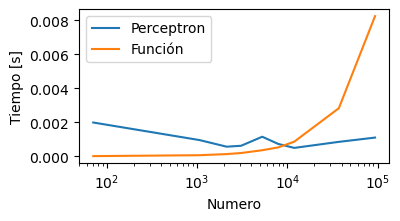

In [28]:
import time
primos_conocidos = [71, 1069, 2129, 3079, 5279, 7919, 11939, 37199, 93719]

tiempos_perc = []
tiempos_func = []
for primo in primos_conocidos:
    t0 = time.time()
    p.forward([primo])
    t1 = time.time()
    es_primo(primo)
    t2 = time.time()

    tiempos_perc.append(t1-t0)
    tiempos_func.append(t2-t1)

ax, fig = plt.subplots(figsize=(4,2))
plt.plot(primos_conocidos, tiempos_perc)
plt.plot(primos_conocidos, tiempos_func)
plt.legend(["Perceptron", "Función"])
plt.xlabel("Numero")
plt.ylabel("Tiempo [s]")
plt.xscale("log")
plt.plot()

# Discriminación de dígito
Hasta acá siempre clasificamos con una sola clase, es decir todo es blanco o negro. Pero para determinar el dígito necesitamos que la salida nos indique bien que dígito es $0..9$.

Estamos en un problema de clasificación multiclase.

Ahora si tiene más sentido el *one-hot-encoding* usado.


In [29]:
x = np.loadtxt("../data/digitos.txt")
y = np.loadtxt("../data/digitos_valor.txt")

In [30]:
optimizer = Adam()
l1 = Layer(35, 10, activation_function="sigmoid")
l2 = Layer(10, 10, activation_function="sigmoid")
p = PerceptronMulticapa([l1, l2], optimizer)
y_enc = p.one_hot_encoding(y)

In [31]:
history = p.train(x, y_enc, epochs=1000)

In [32]:
# Vemos que clasifica todos bien
(p.predict(x) == y).all()

False

## ¿Que sucede usando otros optimizadores?
Vamos a crear una nueva clase de perceptrón.
Le copiamos los pesos y lo entrenamos para cada clasificador.

In [33]:
x = np.loadtxt("../data/digitos.txt")
y = np.loadtxt("../data/digitos_valor.txt")

In [34]:
l1 = Layer(35, 10, activation_function="sigmoid")
l2 = Layer(10, 10, activation_function="sigmoid")
p = PerceptronMulticapa([l1, l2], optimizer=None)
y_enc = p.one_hot_encoding(y)

In [35]:
optimizadores = {
    "SGD": SGD(),
    "Momentum": Momentum(),
    "RMSprop": RMSprop(),
    "AdaGrad": AdaGrad(),
    "Adam": Adam()
}

In [36]:
from copy import deepcopy

history = {}
for name, opt in optimizadores.items():
    p_copy = deepcopy(p)
    p_copy.optimizer = opt
    p_copy.optimizer.learning_rate = 0.001
    history[name] = p_copy.train(x, y_enc, epochs=1000)
    

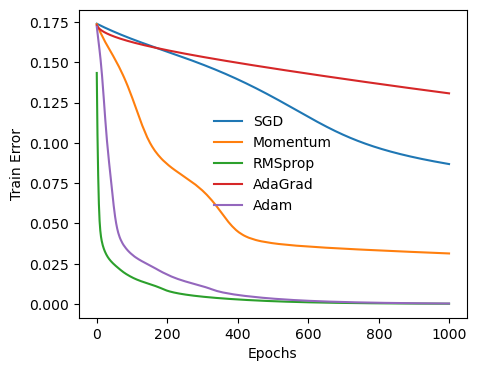

In [37]:
ax, fig = plt.subplots(figsize=(5,4))

for name, h in history.items():
    plt.plot(
        [d["epoch"] for d in h],
        [d["train_loss"] for d in h],
        label=name
    )
plt.ylabel("Train Error")
plt.xlabel("Epochs")
#plt.yscale("log")
plt.legend(frameon=False)
plt.show()

## Learning rate y batch size
El código implementado permite experimentar optimización online o en batch, como también cambiar los párametros de cada clasificador.

Para ver mejores diferencias vamos a tomar el optimizador SGD ya que es el más simple y variar los tamaños del batch y learning rate.

### Learning rate

In [38]:
x = np.loadtxt("../data/digitos.txt")
y = np.loadtxt("../data/digitos_valor.txt")

In [39]:
l1 = Layer(35, 10, activation_function="sigmoid")
l2 = Layer(10, 10, activation_function="sigmoid")
p = PerceptronMulticapa([l1, l2], optimizer=SGD())
y_enc = p.one_hot_encoding(y)

In [40]:
learning_rate = [0.01, 0.1, 1., 10]
history = {}
for lr in learning_rate:
    p_copy = deepcopy(p)
    p_copy.optimizer.learning_rate = lr
    history[lr] = p_copy.train(x, y_enc, epochs=100)


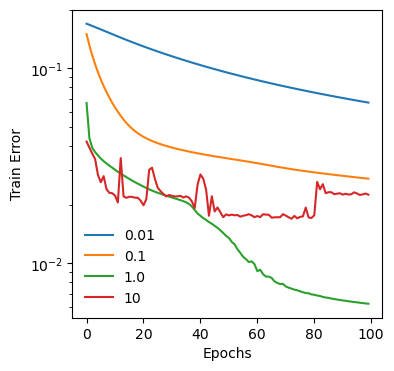

In [41]:
ax, fig = plt.subplots(figsize=(4,4))

for name, h in history.items():
    plt.plot(
        [d["epoch"] for d in h],
        [d["train_loss"] for d in h],
        label=name
    )
plt.ylabel("Train Error")
plt.xlabel("Epochs")
plt.yscale("log")
plt.legend(frameon=False)
plt.show()

A mayor learning rate se ajusta más rapido, pero esto puede traer que el gradiente empiece a zigzaguear.

#### Momentum

In [42]:
learning_rate = [0.01, 0.1, 1., 10]
history = {}
for lr in learning_rate:
    p_copy = deepcopy(p)
    p_copy.optimizer = Momentum()
    p_copy.optimizer.learning_rate = lr
    history[lr] = p_copy.train(x, y_enc, epochs=100)


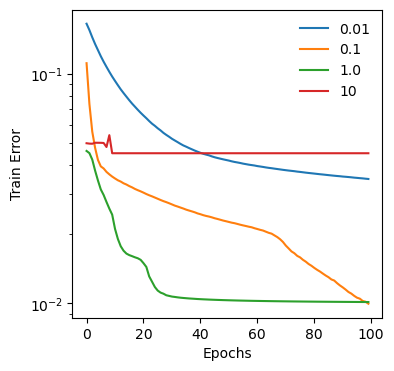

In [43]:
ax, fig = plt.subplots(figsize=(4,4))

for name, h in history.items():
    plt.plot(
        [d["epoch"] for d in h],
        [d["train_loss"] for d in h],
        label=name
    )
plt.ylabel("Train Error")
plt.xlabel("Epochs")
plt.yscale("log")
plt.legend(frameon=False)
plt.show()

Se ve que con el momentum con el learning rate de $0.1$ va más rápido a un menor error.

### Batch size
Para ver algo representativo tomamos un learning rate elevado.

In [44]:
x = np.loadtxt("../data/digitos.txt")
y = np.loadtxt("../data/digitos_valor.txt")

In [45]:
l1 = Layer(35, 10, activation_function="sigmoid")
l2 = Layer(10, 10, activation_function="sigmoid")
p = PerceptronMulticapa([l1, l2], optimizer=SGD())
p.optimizer.learning_rate = 4.
y_enc = p.one_hot_encoding(y)

In [46]:
batch_size = [1, 2, 4, 8, 10]
history = {}
for bs in batch_size:
    p_copy = deepcopy(p)
    history[bs] = p_copy.train(x, y_enc, epochs=100, batch_size=bs)


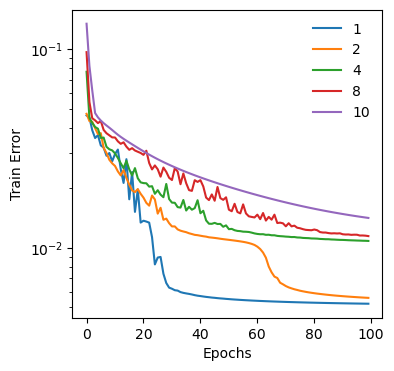

In [47]:
ax, fig = plt.subplots(figsize=(4,4))

for name, h in history.items():
    plt.plot(
        [d["epoch"] for d in h],
        [d["train_loss"] for d in h],
        label=name
    )
plt.ylabel("Train Error")
plt.xlabel("Epochs")
plt.yscale("log")
plt.legend(frameon=False)
plt.show()

### Numeros perturbados por ruido

In [48]:
x = np.loadtxt("../data/digitos.txt")
y = np.loadtxt("../data/digitos_valor.txt")

l1 = Layer(35, 10, activation_function="sigmoid")
l2 = Layer(10, 10, activation_function="sigmoid")
p = PerceptronMulticapa([l1, l2], optimizer=Adam())
y_enc = p.one_hot_encoding(y)

history = p.train(x, y_enc, epochs=1000)

In [49]:
y_hat = p.predict(x)
np.mean(y_hat ==np.array(y))

1.0

Al dataset original vamos a modificar en un bit la entrada y veremos si nuestro clasificador funciona.

In [50]:
bits = 10
x_pert = []
y_pert = []
for i in range(20):
    idx = i % len(x)

    x_mod = x[idx].copy()
    for bit in range(bits):
        bit = np.random.randint(x.shape[0])
        x_mod[bit] = 0 if x_mod[bit] == 1 else 1

    x_pert.append(x_mod)
    y_pert.append(y[idx])

In [51]:
y_hat = p.predict(x_pert)
np.mean(y_hat ==np.array(y_pert))

0.75

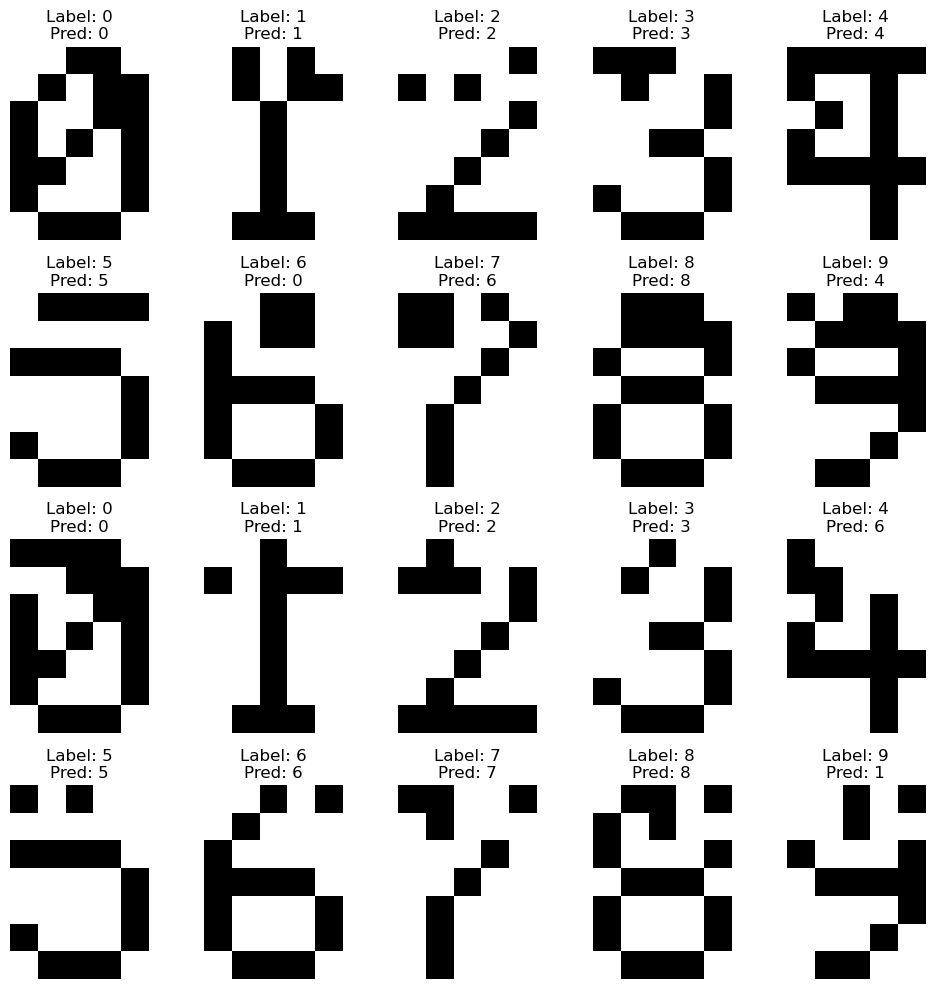

In [52]:
import itertools
n_rows = 4
n_cols = 5
fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 10))
iterable = itertools.product(range(n_rows), range(n_cols))
for n, ij in enumerate(iterable):
    ax[ij].imshow(1 - x_pert[n].reshape(7, 5), cmap="gray")
    ax[ij].set_title("Label: {:.0f}\nPred: {:.0f}".format(y_pert[n], y_hat[n]))
    ax[ij].axis("off")
plt.tight_layout()
plt.show()